Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,113,290 (57.65 MB)

 Trainable params: 397,578 (1.52 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

Epoch 1/10
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 72s 47ms/step - accuracy: 0.5421 - loss: 1.3271 - val_accuracy: 0.6537 - val_loss: 0.9794
Epoch 2/10
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 78s 45ms/step - accuracy: 0.6503 - loss: 1.0038 - val_accuracy: 0.6780 - val_loss: 0.9220
Epoch 3/10
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 83s 46ms/step - accuracy: 0.6714 - loss: 0.9464 - val_accuracy: 0.6947 - val_loss: 0.8761
Epoch 4/10
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.6799 - loss: 0.9128 - val_accuracy: 0.7013 - val_loss: 0.8570
Epoch 5/10
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - accuracy: 0.6875 - loss: 0.8895 - val_accuracy: 0.7030 - val_loss: 0.8499
Epoch 6/10
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 83s 46ms/step - accuracy: 0.6977 - loss: 0.8676 - val_accuracy: 0.6993 - val_loss: 0.8406
Epoch 7/10
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.7083 - loss: 0.8416 - val_accuracy: 0.7057 - val_loss: 0.8292
Epoch 8/10
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 68s 46ms/step - accuracy: 0.7089 -

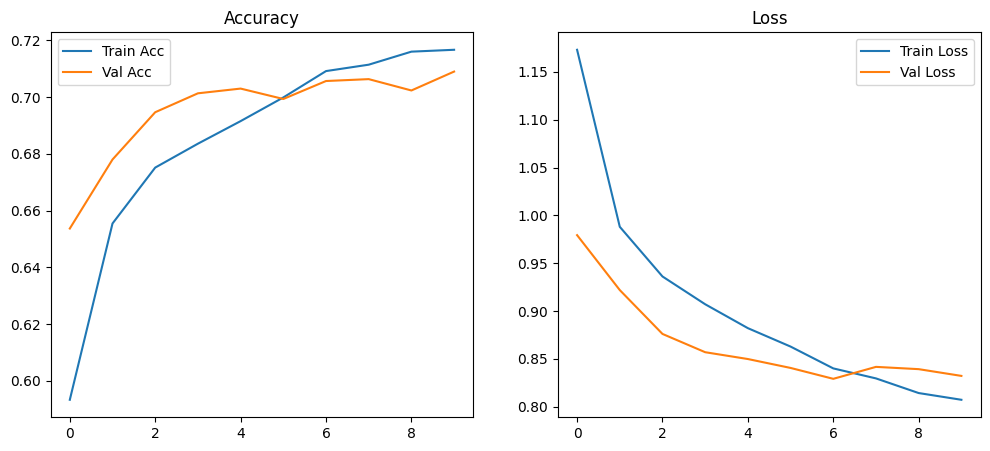

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16

# Load and preprocess data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val = X_train[3000:], X_train[:3000]
y_train, y_val = y_train[3000:], y_train[:3000]

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Preprocessing function for tf.data
def preprocess(image, label):
    image = tf.image.resize(image, [96, 96])   # Resize on the fly
    image = tf.cast(image, tf.float32) / 255.0   # Normalize
    return image, label

# Create tf.data datasets
BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Load VGG16 base model
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(96,96,3))
base_model.trainable = False  # Freeze layers

# Define full model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

model.summary()

# Callbacks
checkpoint = ModelCheckpoint('best_model.weights.h5', monitor='val_loss', save_weights_only=True, save_best_only=True)
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

# Compile and train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, batch_size=128, epochs=10, callbacks=[checkpoint, early_stop])

# Evaluate
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.4f} - Test Loss: {loss:.4f}")

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()
